In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings

from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from keras.models import Model, Sequential, load_model

from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from keras_radam import RAdam

warnings.filterwarnings('ignore')
%matplotlib inline

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


# Dot Product with RMSE loss function

In [2]:
from helpers import load_data

DATA_TRAIN_PATH = "data/data_train.csv"
ratings = load_data(DATA_TRAIN_PATH)

DATA_TEST_PATH = "data/sampleSubmission.csv"
samples = load_data(DATA_TEST_PATH)

In [3]:
samples.head()

,user_id,movie_id,rating
0,37,1,3
1,73,1,3
2,156,1,3
3,160,1,3
4,248,1,3


In [4]:
n_users = len(ratings.user_id.unique())
n_movies = len(ratings.movie_id.unique())

In [5]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(ratings, test_size=0.1, random_state=42)

In [6]:
test.head()

,user_id,movie_id,rating
904556,5062,706,2
171326,9044,148,4
190893,1736,169,4
1082109,5270,877,1
881877,6100,691,4


In [7]:
from keras import losses
from keras.utils import to_categorical
from keras import backend
from keras.regularizers import l2

K = 25;

#creating movie embedding path
movie_input = Input(shape=[1], name="Movie-Input")
movie_embedding = Embedding(n_movies+1, K, name="Movie-Embedding", embeddings_regularizer=l2(1e-6))(movie_input)
movie_vec = Flatten(name="Flatten-Movies")(movie_embedding)

# creating user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users+1, K, name="User-Embedding", embeddings_regularizer=l2(1e-6))(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

# performing dot product and creating model
prod = Dot(name="Dot-Product", axes=1)([movie_vec, user_vec])
model = Model([user_input, movie_input], prod)
model.compile(loss='mean_squared_error', optimizer=RAdam(), metrics=['accuracy'])

# Optimizer : 'sgd', adam', RAdam(), 
# Loss = 'mean_squared_error'


Epoch 1/20
1059256/1059256 [==============================] - 10s 10us/step - loss: 14.3249 - accuracy: 0.0081
Epoch 2/20
1059256/1059256 [==============================] - 10s 9us/step - loss: 1.7565 - accuracy: 0.2870
Epoch 3/20
1059256/1059256 [==============================] - 10s 10us/step - loss: 1.0423 - accuracy: 0.3610
Epoch 4/20
1059256/1059256 [==============================] - 10s 9us/step - loss: 1.0352 - accuracy: 0.3603
Epoch 5/20
1059256/1059256 [==============================] - 10s 9us/step - loss: 1.0350 - accuracy: 0.3602
Epoch 6/20
1059256/1059256 [==============================] - 11s 10us/step - loss: 1.0348 - accuracy: 0.3602
Epoch 7/20
1059256/1059256 [==============================] - 9s 9us/step - loss: 1.0338 - accuracy: 0.3604
Epoch 8/20
1059256/1059256 [==============================] - 12s 11us/step - loss: 1.0325 - accuracy: 0.3605
Epoch 9/20
1059256/1059256 [==============================] - 10s 9us/step - loss: 1.0302 - accuracy: 0.3607
Epoch 10/20
10

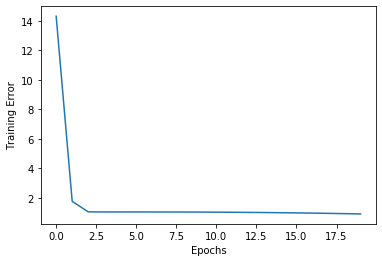

In [8]:
if os.path.exists('regression_model.h5'):
    model = load_model('regression_model.h5')
else:
    history = model.fit([train.user_id, train.movie_id], train.rating, batch_size=1000, epochs=20, verbose=1)
    model.save('regression_model.h5')
    plt.plot(history.history['loss'])
    plt.xlabel("Epochs")
    plt.ylabel("Training Error")

In [9]:
model.evaluate([test.user_id, test.movie_id], test.rating)

117696/117696 [==============================] - 3s 27us/step


[1.027099850240643, 0.37516143918037415]

In [10]:
pred = model.predict([test.user_id.head(10), test.movie_id.head(10)])

[print(pred[i], test.rating.iloc[i]) for i in range(0,10)]

[3.199545] 2
[3.4799664] 4
[4.458121] 4
[3.6820173] 1
[3.7638707] 4
[5.0317135] 4
[3.2837343] 5
[4.45392] 4
[5.0316014] 4
[5.1806426] 5


[None, None, None, None, None, None, None, None, None, None]

In [11]:
pred = model.predict([samples.user_id, samples.movie_id])

In [12]:
np.asarray(pred)

array([[3.0432405],
       [3.1560335],
       [3.6740422],
       ...,
       [3.1113799],
       [3.3058915],
       [3.844506 ]], dtype=float32)

In [13]:
for i in range(pred.shape[0]):
    pred[i] = np.round(pred[i])
    if (pred[i] < 1):
        pred[i] = 1
    elif (pred[i] > 5):
        pred[i] = 5

In [14]:
pred

array([[3.],
       [3.],
       [4.],
       ...,
       [3.],
       [3.],
       [4.]], dtype=float32)

In [15]:
submission = load_data(DATA_TEST_PATH)
submission['rating'] = pred
submission

,user_id,movie_id,rating
0,37,1,3.0
1,73,1,3.0
2,156,1,4.0
3,160,1,3.0
4,248,1,3.0
...,...,...,...
1176947,9974,1000,4.0
1176948,9977,1000,4.0
1176949,9978,1000,3.0
1176950,9982,1000,3.0


In [16]:
from helpers import create_csv

DATA_SUBMISSION = "data/submission_dotprodRMSE.csv"
create_csv(DATA_SUBMISSION, submission)

Dot Product with RMSE using librairies : pandas and keras - AICrowd : RMSE = 1.039 ; Secondary = 0.136

The score stays the same when we increase 'epoch' or 'K'.

# Dot Product with Cross validation

In [ ]:
n_split=3

X = ratings[['user', 'movie']].values
y = ratings['rating']

if os.path.exists('regression_model.h5'):
    model = load_model('regression_model.h5')
else:
    for train_index, test_index in KFold(n_split).split(X):
        x_train, x_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
  
        model=create_model()
        history = model.fit(x_train, y_train, batch_size=1000, epochs=20, verbose=1)
    
    history = model.fit([train.user_id, train.movie_id], train.rating, )
    model.save('regression_model.h5')
    plt.plot(history.history['loss'])
    plt.xlabel("Epochs")
    plt.ylabel("Training Error")
    
    
  
    print('Model evaluation ',model.evaluate(x_test,y_test))